## Model Evaluation Analysis Report
---
*Detailed Performance Metrics and Visualizations for Checkpoint Evaluation*

# Cell 1: Imports, Setup, Configuration


In [3]:
print("[INFO] Starting script: Loading libraries and configuring environment...")

import os
import glob
import ctypes
import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, mixed_precision
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, accuracy_score, mean_squared_error, mean_absolute_error
)
import seaborn as sns # For plotting confusion matrix nicely
import traceback      # For printing detailed errors on exceptions
import time           # To add timestamp to filenames

print(f"[INFO] Script execution started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"[INFO] TensorFlow Version: {tf.__version__}")
print(f"[INFO] NumPy Version: {np.__version__}")
print(f"[INFO] Pandas Version: {pd.__version__}")

# --- Mixed Precision Policy ---
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("[INFO] Mixed precision ('mixed_float16') policy set globally.")
except Exception as e:
    print(f"[WARNING] Could not set mixed precision policy: {e}. Proceeding without.")

# --- ZLIB DLL Fix for Windows (Optional) ---
try:
    conda_prefix = os.environ.get('CONDA_PREFIX', None)
    dll_path = None
    if conda_prefix:
        potential_path = os.path.join(conda_prefix, 'Library', 'bin', 'zlibwapi.dll')
        if os.path.exists(potential_path):
            dll_path = potential_path
            print(f"[INFO] Found zlibwapi.dll in Conda environment: {dll_path}")
    if dll_path:
        ctypes.CDLL(dll_path)
        print("[INFO] Successfully loaded zlibwapi.dll.")
    else:
        print("[INFO] zlibwapi.dll not found or CONDA_PREFIX not set. Skipping load.")
except Exception as e:
    print(f"[INFO] Optional zlibwapi.dll loading skipped or failed (often okay): {e}")

# --- GPU Configuration ---
print("[INFO] Detecting and configuring GPUs...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"[INFO] Using {len(gpus)} Physical GPU(s) -> {len(logical_gpus)} Logical GPU(s).")
        details = tf.config.experimental.get_device_details(gpus[0])
        print(f"       GPU 0 Name: {details.get('device_name', 'N/A')}")
    except RuntimeError as e:
        print(f"[ERROR] GPU configuration failed: {e}. Using CPU.")
        gpus = []
else:
    print("[WARNING] No GPU detected by TensorFlow. Using CPU (may be slow).")

# --- Configuration Parameters ---
print("[CONFIG] Setting configuration parameters...")
DATA_DIR        = r"C:\college\CV\COSMOS\6C_full"
CHECKPOINT_PATH = r"C:\college\CV\COSMOS\checkpoints\model_epoch_11.h5" # << MODIFY THIS AS NEEDED
SEQ_LEN         = 4
PATCH_SIZE      = 32
EVAL_BATCH_SIZE = 32
THRESHOLD       = 265.0
CV_THRESHOLD    = 260.0
FOG_THRESHOLD   = 270.0
EVAL_SUBSET_FRACTION = 0.3 # Evaluate on 30% of validation data (adjust 0.0 to 1.0)

print(f"[CONFIG] Data Directory: {DATA_DIR}")
print(f"[CONFIG] Checkpoint for evaluation: {CHECKPOINT_PATH}")
print(f"[CONFIG] Input Sequence Length: {SEQ_LEN}")
print(f"[CONFIG] Patch Size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"[CONFIG] Evaluation Batch Size: {EVAL_BATCH_SIZE}")
print(f"[CONFIG] Evaluation subset fraction: {EVAL_SUBSET_FRACTION:.2f} ({EVAL_SUBSET_FRACTION*100:.0f}%)")

# --- Validate Configuration ---
if not os.path.isdir(DATA_DIR): raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
if not os.path.exists(CHECKPOINT_PATH): raise FileNotFoundError(f"Checkpoint file not found: {CHECKPOINT_PATH}")
if not 0.0 < EVAL_SUBSET_FRACTION <= 1.0: raise ValueError("EVAL_SUBSET_FRACTION must be > 0.0 and <= 1.0.")

# --- Load File Sequences ---
print("[INFO] Scanning for HDF5 files and creating sequences...")
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.h5")))
if not all_files: raise FileNotFoundError(f"No HDF5 files found in {DATA_DIR}")
sequences = [all_files[i:i + SEQ_LEN + 1] for i in range(len(all_files) - SEQ_LEN)]
if not sequences: raise ValueError(f"Not enough files ({len(all_files)}) for sequences of length {SEQ_LEN + 1}.")
print(f"[INFO] Found {len(all_files)} files, created {len(sequences)} total sequences.")

# --- Define Train/Validation Split & Subset ---
split_index = int((1.0 - 0.1) * len(sequences)) # 90% train, 10% validation
full_eval_seqs = sequences[split_index:]
if not full_eval_seqs: raise ValueError("No evaluation sequences after 90/10 split.")
num_eval_subset = max(1, int(EVAL_SUBSET_FRACTION * len(full_eval_seqs)))
eval_seqs_subset = full_eval_seqs[:num_eval_subset]
print(f"[INFO] Total sequences split: {len(sequences[:split_index])} train, {len(full_eval_seqs)} validation.")
print(f"[INFO] Using subset for evaluation: {len(eval_seqs_subset)} sequences ({EVAL_SUBSET_FRACTION*100:.1f}% of validation).")

# --- Helper Function: Extract Epoch ---
def get_epoch_from_filename(fname):
    match = re.search(r"epoch_(\d+)", os.path.basename(fname))
    return int(match.group(1)) if match else -1 # Return -1 if no epoch number found


[INFO] Starting script: Loading libraries and configuring environment...
[INFO] Script execution started at: 2025-05-03 17:53:49
[INFO] TensorFlow Version: 2.10.0
[INFO] NumPy Version: 1.26.4
[INFO] Pandas Version: 2.2.3
[INFO] Mixed precision ('mixed_float16') policy set globally.
[INFO] Found zlibwapi.dll in Conda environment: C:\Users\dhanu\.conda\envs\w\Library\bin\zlibwapi.dll
[INFO] Successfully loaded zlibwapi.dll.
[INFO] Detecting and configuring GPUs...
[INFO] Using 1 Physical GPU(s) -> 1 Logical GPU(s).
       GPU 0 Name: NVIDIA GeForce RTX 3060 Laptop GPU
[CONFIG] Setting configuration parameters...
[CONFIG] Data Directory: C:\college\CV\COSMOS\6C_full
[CONFIG] Checkpoint for evaluation: C:\college\CV\COSMOS\checkpoints\model_epoch_11.h5
[CONFIG] Input Sequence Length: 4
[CONFIG] Patch Size: 32x32
[CONFIG] Evaluation Batch Size: 32
[CONFIG] Evaluation subset fraction: 0.30 (30%)
[INFO] Scanning for HDF5 files and creating sequences...
[INFO] Found 900 files, created 896 tota

# Cell 2: Evaluation Data Loader (WITH Random Cropping)


In [4]:
print("\n[INFO] Defining data loading and processing functions...")

def load_eval_data(file_path_sequence):
    # (Content of this function remains the same as in the previous response)
    # Loads SEQ_LEN+1 frames, applies LUTs, normalizes, generates target labels (y dictionary).
    # Returns (X, y) or (None, None) on error.
    if len(file_path_sequence) != SEQ_LEN + 1: return None, None
    input_frames = []
    for i, fp in enumerate(file_path_sequence[:SEQ_LEN]):
        try:
            with h5py.File(fp, 'r') as f:
                cnt1 = f['IMG_TIR1'][0][...]
                cnt2 = f['IMG_TIR2'][0][...]
                cnt_wv = f['IMG_WV'][0][...]
                cnt_mir = f['IMG_MIR'][0][...]
                cnt_vis = f['IMG_VIS'][0][...]
                lut1 = f['IMG_TIR1_TEMP'][:]
                lut2 = f['IMG_TIR2_TEMP'][:]
                lut_wv = f['IMG_WV_TEMP'][:]
                lut_mir = f['IMG_MIR_TEMP'][:]
                lut_vis = f['IMG_VIS_ALBEDO'][:]
                bt1, bt2 = lut1[cnt1], lut2[cnt2]
                wv, mir, vis = lut_wv[cnt_wv], lut_mir[cnt_mir], lut_vis[cnt_vis]
                # Assuming order [BT1, BT2, WV, MIR, VIS] and normalization /300.0
                frame_data = np.stack([bt1, bt2, wv, mir, vis], axis=-1) / 300.0
                input_frames.append(frame_data)
        except Exception as e:
            print(f"[ERROR] Data Loader (Input): Failed loading {fp}: {e}")
            return None, None
    if len(input_frames) != SEQ_LEN: return None, None
    X = np.stack(input_frames, axis=0).astype(np.float32)

    target_fp = file_path_sequence[-1]
    try:
        with h5py.File(target_fp, 'r') as f:
            cnt1_t, cnt2_t = f['IMG_TIR1'][0][...], f['IMG_TIR2'][0][...]
            cnt_wv_t, cnt_mir_t = f['IMG_WV'][0][...], f['IMG_MIR'][0][...]
            lut1_t, lut2_t = f['IMG_TIR1_TEMP'][:], f['IMG_TIR2_TEMP'][:]
            lut_wv_t, lut_mir_t = f['IMG_WV_TEMP'][:], f['IMG_MIR_TEMP'][:]
            bt1_t, bt2_t = lut1_t[cnt1_t], lut2_t[cnt2_t]
            wv_t, mir_t = lut_wv_t[cnt_wv_t], lut_mir_t[cnt_mir_t]

            # Generate labels (MUST match training generation)
            cloud_label = (bt1_t < THRESHOLD).astype(np.float32)[..., np.newaxis]
            convective_label = (bt1_t < CV_THRESHOLD).astype(np.float32)[..., np.newaxis]
            fog_label = (mir_t < FOG_THRESHOLD).astype(np.float32)[..., np.newaxis]
            moisture_label = (wv_t / 300.0).astype(np.float32)[..., np.newaxis]
            thermo_contrast_label = ((bt2_t - bt1_t) / 100.0).astype(np.float32)[..., np.newaxis]
            last_mean_bt1_norm = np.mean(bt1_t / 300.0)
            first_mean_bt1_norm = np.mean(X[0, ..., 0]) # Assumes BT1 is channel 0
            temp_trend_label = np.array([last_mean_bt1_norm - first_mean_bt1_norm], dtype=np.float32)

            y = {'cloud': cloud_label, 'convective': convective_label, 'fog': fog_label,
                 'moisture': moisture_label, 'thermo_contrast': thermo_contrast_label,
                 'temp_trend': temp_trend_label}
            return X, y
    except Exception as e:
        print(f"[ERROR] Data Loader (Target): Failed loading {target_fp}: {e}")
        return None, None

def random_crop(X_full, y_full_dict, patch_size=PATCH_SIZE):
    # (Content of this function remains the same)
    # Applies random crop to X and spatial y maps. Returns (X_patch, y_patch_dict) or (None, None).
    if X_full is None: return None, None
    H, W = X_full.shape[1], X_full.shape[2]
    if H < patch_size or W < patch_size: return None, None
    max_i, max_j = H - patch_size, W - patch_size
    i, j = np.random.randint(0, max_i + 1), np.random.randint(0, max_j + 1)
    X_patch = X_full[:, i:i + patch_size, j:j + patch_size, :]
    y_patch_dict = {}
    for task_name, target_data in y_full_dict.items():
        if target_data.ndim >= 2 and target_data.shape[0] == H and target_data.shape[1] == W:
            y_patch_dict[task_name] = target_data[i:i + patch_size, j:j + patch_size]
        else:
            y_patch_dict[task_name] = target_data # Keep non-spatial targets
    return X_patch, y_patch_dict

def evaluation_generator(sequences_to_process):
    # (Content of this function remains the same)
    # Generates (X_patch, y_patch) tuples for the tf.data pipeline.
    print(f"[Generator] Initializing evaluation generator for {len(sequences_to_process)} sequences...")
    num_yielded = 0
    sequences_copy = list(sequences_to_process)
    while num_yielded < len(sequences_to_process):
        np.random.shuffle(sequences_copy)
        initial_yields_in_loop = num_yielded
        for file_seq in sequences_copy:
            X_full, y_full = load_eval_data(file_seq)
            if X_full is not None and y_full is not None:
                X_patch, y_patch = random_crop(X_full, y_full, patch_size=PATCH_SIZE)
                if X_patch is not None and y_patch is not None:
                    yield X_patch, y_patch
                    num_yielded += 1
                    if num_yielded >= len(sequences_to_process):
                        print(f"\n[Generator] Successfully yielded {num_yielded} samples. Generator finished.")
                        return
        if num_yielded == initial_yields_in_loop and num_yielded < len(sequences_to_process):
            print(f"\n[Generator WARNING] Failed to yield more valid samples ({num_yielded}/{len(sequences_to_process)}). Check data or cropping. Stopping.")
            return

# --- Define TensorFlow Dataset Output Signature ---
print("[INFO] Defining TensorFlow Dataset structure (output signature)...")
eval_output_signature = (
    tf.TensorSpec(shape=(SEQ_LEN, PATCH_SIZE, PATCH_SIZE, 5), dtype=tf.float32), # Input X
    { # Output Y dictionary
        'cloud': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'convective': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'fog': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'moisture': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'thermo_contrast': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'temp_trend': tf.TensorSpec(shape=(1,), dtype=tf.float32)
    }
)
print("[INFO] Output signature defined.")

# --- Create and Optimize TensorFlow Dataset ---
print("[INFO] Creating TensorFlow Dataset from generator...")
eval_ds = tf.data.Dataset.from_generator(
    lambda: evaluation_generator(eval_seqs_subset),
    output_signature=eval_output_signature
).cache().batch(EVAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(f"[INFO] Evaluation tf.data.Dataset created (Target Samples: {len(eval_seqs_subset)}, Batch Size: {EVAL_BATCH_SIZE}).")



[INFO] Defining data loading and processing functions...
[INFO] Defining TensorFlow Dataset structure (output signature)...
[INFO] Output signature defined.
[INFO] Creating TensorFlow Dataset from generator...
[INFO] Evaluation tf.data.Dataset created (Target Samples: 27, Batch Size: 32).


# Cell 3: Evaluate Single Checkpoint on the Subset


In [5]:
print("\n" + "="*60)
print("[EVAL] Starting Model Evaluation on the Defined Subset")
print("="*60)

evaluation_results = {}
ckpt_path_to_eval = CHECKPOINT_PATH
epoch_number = get_epoch_from_filename(ckpt_path_to_eval)
print(f"[EVAL] Target Checkpoint: {os.path.basename(ckpt_path_to_eval)} (Detected Epoch: {epoch_number if epoch_number != -1 else 'Unknown'})")

# Variables to store data needed for Cell 5 visualization
predictions = None
true_labels = None
model = None
actual_num_samples_for_metrics = 0

try:
    print("[EVAL] Loading model architecture and weights...")
    model = tf.keras.models.load_model(ckpt_path_to_eval, compile=True)
    print("[EVAL] Model loaded successfully.")

    eval_steps = int(np.ceil(len(eval_seqs_subset) / EVAL_BATCH_SIZE))
    print(f"[EVAL] Calculated evaluation steps: {eval_steps}")

    print(f"[EVAL] Generating predictions using model.predict()...")
    predictions = model.predict(eval_ds, steps=eval_steps, verbose=1)
    print(f"[EVAL] Predictions generated.")

    print(f"[EVAL] Gathering ground truth labels corresponding to predictions...")
    true_labels = {task_name: [] for task_name in model.output_names}
    num_labels_gathered = 0
    for _, y_batch_dict in tqdm(eval_ds.take(eval_steps), desc="[EVAL] Gathering Labels", total=eval_steps, unit="batch"):
        batch_size_current = 0
        for task_name in true_labels.keys():
            if task_name in y_batch_dict:
                batch_labels = y_batch_dict[task_name].numpy()
                true_labels[task_name].append(batch_labels)
                if task_name == model.output_names[0]: batch_size_current = batch_labels.shape[0]
            else: print(f"[WARNING] Task '{task_name}' missing in labels batch.")
        num_labels_gathered += batch_size_current
    print(f"[EVAL] Finished gathering labels. Total samples gathered: {num_labels_gathered}")

    print("[EVAL] Concatenating gathered label batches...")
    num_pred_samples = 0
    try:
        for task_name in true_labels.keys():
            if true_labels[task_name]:
                true_labels[task_name] = np.concatenate(true_labels[task_name], axis=0)
                if task_name == model.output_names[0]: num_pred_samples = predictions[task_name].shape[0]
            else:
                print(f"[WARNING] No labels gathered for task '{task_name}'.")
                true_labels[task_name] = None
    except ValueError as e: print(f"[ERROR] Failed concatenate labels for '{task_name}': {e}."); true_labels[task_name] = None

    print(f"[EVAL] Verifying alignment: Predictions={num_pred_samples}, Labels={num_labels_gathered}")
    if num_pred_samples != num_labels_gathered:
        print(f"[WARNING] Mismatch found. Truncating to {min(num_pred_samples, num_labels_gathered)} samples.")
        min_samples = min(num_pred_samples, num_labels_gathered)
        actual_num_samples_for_metrics = min_samples
        for task_name in predictions.keys():
            if predictions[task_name] is not None: predictions[task_name] = predictions[task_name][:min_samples]
            if task_name in true_labels and true_labels[task_name] is not None: true_labels[task_name] = true_labels[task_name][:min_samples]
    elif num_pred_samples == 0:
        print("[WARNING] Both predictions and labels are empty. No metrics possible.")
        actual_num_samples_for_metrics = 0
    else:
        print("[INFO] Prediction and label counts match.")
        actual_num_samples_for_metrics = num_pred_samples

    if actual_num_samples_for_metrics > 0:
        print(f"\n[EVAL] Calculating metrics based on {actual_num_samples_for_metrics} aligned samples...")
        epoch_metrics_results = {'epoch': epoch_number}
        for task_name in model.output_names:
            print(f"    Processing Task: '{task_name}'")
            if task_name not in predictions or predictions[task_name] is None or task_name not in true_labels or true_labels[task_name] is None:
                print(f"      Skipping task '{task_name}': Missing predictions or labels."); continue
            y_true_task, y_pred_task = true_labels[task_name], predictions[task_name]
            if y_true_task.shape[0] != actual_num_samples_for_metrics or y_pred_task.shape[0] != actual_num_samples_for_metrics:
                 print(f"      Skipping task '{task_name}': Shape mismatch after truncation."); continue

            is_classification = task_name in ['cloud', 'convective', 'fog']
            print(f"      Task type: {'Classification' if is_classification else 'Regression'}")
            try:
                if is_classification:
                    y_true_flat, y_pred_flat = y_true_task.flatten(), y_pred_task.flatten()
                    y_pred_binary = (y_pred_flat >= 0.5).astype(int)
                    accuracy = accuracy_score(y_true_flat, y_pred_binary)
                    precision = precision_score(y_true_flat, y_pred_binary, zero_division=0)
                    recall = recall_score(y_true_flat, y_pred_binary, zero_division=0)
                    f1 = f1_score(y_true_flat, y_pred_binary, zero_division=0)
                    cm = confusion_matrix(y_true_flat, y_pred_binary, labels=[0, 1]) # Ensure labels are 0, 1
                    # Handle case where cm might not be 2x2 if only one class present
                    if cm.shape != (2, 2):
                        print(f"      [WARNING] Confusion matrix for '{task_name}' is not 2x2 (shape: {cm.shape}). May indicate only one class present/predicted. Padding to 2x2.")
                        cm_padded = np.zeros((2, 2), dtype=int)
                        # Assuming labels=[0,1] mapping: TN=cm[0,0], FP=cm[0,1], FN=cm[1,0], TP=cm[1,1]
                        # This part needs careful handling based on actual `confusion_matrix` output structure if not 2x2
                        if cm.shape == (1, 1): # Only one class present and predicted correctly/incorrectly
                             present_class_label = np.unique(y_true_flat)[0] # Find which class (0 or 1) is present
                             if present_class_label == 0: cm_padded[0, 0] = cm[0, 0] # All were TN
                             else: cm_padded[1, 1] = cm[0, 0] # All were TP
                        cm = cm_padded # Use the padded version

                    epoch_metrics_results.update({
                        f'{task_name}_accuracy': accuracy, f'{task_name}_precision': precision,
                        f'{task_name}_recall': recall, f'{task_name}_f1': f1,
                        f'{task_name}_confusion_matrix': cm
                    })
                    print(f"        Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
                else: # Regression
                    y_true_flat = y_true_task.flatten() if y_true_task.ndim > 1 else y_true_task
                    y_pred_flat = y_pred_task.flatten() if y_pred_task.ndim > 1 else y_pred_task
                    mse = mean_squared_error(y_true_flat, y_pred_flat)
                    mae = mean_absolute_error(y_true_flat, y_pred_flat)
                    epoch_metrics_results.update({f'{task_name}_mse': mse, f'{task_name}_mae': mae})
                    print(f"        MSE: {mse:.6f}, MAE: {mae:.6f}")
            except Exception as metric_error: print(f"[ERROR] Metric calculation failed for '{task_name}': {metric_error}")
        evaluation_results[ckpt_path_to_eval] = epoch_metrics_results
        print("[EVAL] Metrics calculation completed.")
    else:
        print("[EVAL] Skipping metric calculation as no aligned samples found.")
        evaluation_results[ckpt_path_to_eval] = {'epoch': epoch_number, 'error': 'No aligned samples found'}

except Exception as e:
    print(f"[ERROR] Evaluation phase failed: {e}")
    traceback.print_exc()
    evaluation_results[ckpt_path_to_eval] = {'epoch': epoch_number, 'error': f"Evaluation failed: {e}"}
    # Ensure model is None if loading failed, to prevent errors in Cell 5
    model = None

print("\n[EVAL] Evaluation Phase Finished.")



[EVAL] Starting Model Evaluation on the Defined Subset
[EVAL] Target Checkpoint: model_epoch_11.h5 (Detected Epoch: 11)
[EVAL] Loading model architecture and weights...
[EVAL] Model loaded successfully.
[EVAL] Calculated evaluation steps: 1
[EVAL] Generating predictions using model.predict()...
[Generator] Initializing evaluation generator for 27 sequences...

[Generator] Successfully yielded 27 samples. Generator finished.
1/1 [==============================] - 97s 97s/step
[EVAL] Predictions generated.
[EVAL] Gathering ground truth labels corresponding to predictions...


[EVAL] Gathering Labels: 100%|██████████| 1/1 [00:00<00:00, 28.42batch/s]

[EVAL] Finished gathering labels. Total samples gathered: 27
[EVAL] Concatenating gathered label batches...
[EVAL] Verifying alignment: Predictions=27, Labels=27
[INFO] Prediction and label counts match.

[EVAL] Calculating metrics based on 27 aligned samples...
    Processing Task: 'cloud'
      Task type: Classification
        Accuracy: 0.7610, Precision: 0.6013, Recall: 0.9948, F1-Score: 0.7496
    Processing Task: 'convective'
      Task type: Classification
        Accuracy: 0.8078, Precision: 0.5945, Recall: 0.9950, F1-Score: 0.7443
    Processing Task: 'fog'
      Task type: Classification
        Accuracy: 0.8651, Precision: 0.5941, Recall: 0.9245, F1-Score: 0.7234
    Processing Task: 'moisture'
      Task type: Regression
        MSE: 1.069679, MAE: 1.017099
    Processing Task: 'temp_trend'
      Task type: Regression
        MSE: 0.070033, MAE: 0.238688
    Processing Task: 'thermo_contrast'
      Task type: Regression
        MSE: 0.090709, MAE: 0.274848
[EVAL] Metrics ca

# Cell 4: Results Presentation and Saving


In [6]:
print("\n" + "="*60)
print("[RESULTS] Summarizing and Saving Evaluation Results")
print("="*60)

final_metrics = evaluation_results.get(ckpt_path_to_eval, {})
subset_percent_str = f"{EVAL_SUBSET_FRACTION*100:.0f}pct" # For filenames/titles

if not final_metrics or 'error' in final_metrics:
    print(f"[ERROR] Evaluation failed or produced no results for {os.path.basename(ckpt_path_to_eval)}.")
    if 'error' in final_metrics: print(f"        Error details: {final_metrics['error']}")
else:
    print(f"\n--- Metrics for Checkpoint: {os.path.basename(ckpt_path_to_eval)} (Epoch {final_metrics.get('epoch', 'N/A')}) ---")
    print(f"--- Evaluated on {actual_num_samples_for_metrics} samples ({subset_percent_str} of validation set) ---")
    metrics_for_display = [{'Metric': k, 'Value': v} for k, v in sorted(final_metrics.items()) if k != 'epoch' and 'confusion_matrix' not in k]
    if metrics_for_display:
        metrics_df = pd.DataFrame(metrics_for_display)
        metrics_df['Value'] = metrics_df['Value'].apply(lambda x: f"{x:.6f}" if isinstance(x, (float, np.floating)) else x)
        print("\nMetrics Summary Table:")
        print(metrics_df.to_string(index=False, justify='left', col_space=15))
    else: print("\nNo displayable metrics were calculated.")

    output_dir = os.path.dirname(ckpt_path_to_eval) or '.' # Use '.' if ckpt path has no dir
    epoch_str = f"epoch_{epoch_number}" if epoch_number != -1 else "epoch_unknown"
    csv_filename = f"evaluation_metrics_{epoch_str}_subset_{subset_percent_str}.csv"
    csv_path = os.path.join(output_dir, csv_filename)
    print(f"\n[RESULTS] Attempting to save metrics to CSV: {csv_path}")
    try:
        metrics_to_save = {k: v for k, v in final_metrics.items() if k != 'error' and 'confusion_matrix' not in k}
        metrics_save_df = pd.DataFrame([metrics_to_save])
        metrics_save_df['checkpoint_file'] = os.path.basename(ckpt_path_to_eval)
        metrics_save_df['subset_fraction'] = EVAL_SUBSET_FRACTION
        metrics_save_df['num_eval_samples'] = actual_num_samples_for_metrics
        cols_order = ['checkpoint_file', 'epoch', 'subset_fraction', 'num_eval_samples'] + sorted([col for col in metrics_save_df.columns if col not in ['checkpoint_file', 'epoch', 'subset_fraction', 'num_eval_samples']])
        metrics_save_df = metrics_save_df[cols_order]
        metrics_save_df.to_csv(csv_path, index=False, float_format='%.8f')
        print(f"[RESULTS] Metrics successfully saved to: {csv_path}")
    except Exception as e: print(f"[ERROR] Failed to save metrics to CSV: {e}")



[RESULTS] Summarizing and Saving Evaluation Results

--- Metrics for Checkpoint: model_epoch_11.h5 (Epoch 11) ---
--- Evaluated on 27 samples (30pct of validation set) ---

Metrics Summary Table:
Metric               Value          
      cloud_accuracy 0.760959       
            cloud_f1 0.749574       
     cloud_precision 0.601350       
        cloud_recall 0.994770       
 convective_accuracy 0.807762       
       convective_f1 0.744287       
convective_precision 0.594497       
   convective_recall 0.994983       
        fog_accuracy 0.865090       
              fog_f1 0.723376       
       fog_precision 0.594104       
          fog_recall 0.924550       
        moisture_mae 1.017099       
        moisture_mse 1.069679       
      temp_trend_mae 0.238688       
      temp_trend_mse 0.070033       
 thermo_contrast_mae 0.274848       
 thermo_contrast_mse 0.090709       

[RESULTS] Attempting to save metrics to CSV: C:\college\CV\COSMOS\checkpoints\evaluation_metrics_ep

# Cell 5: Visualization (Separate Plots with Descriptions)



[VISUALIZATION] Generating Diagnostic Plots

[VIS] Attempting to generate Sample Prediction vs Ground Truth plot...
[VIS] Retrieved one sample batch from the dataset.
[VIS] Generating predictions for the sample batch...
[VIS] Plotting input sequence patches...
[VIS] Plotting True vs Predicted maps for spatial tasks...

[VIS] Non-Spatial Task Predictions for this Sample:
      Temp_trend: True=-0.0047, Pred=0.3931 (Overall MAE: 0.238688)

[VIS] Sample prediction plot saved successfully to: C:\college\CV\COSMOS\checkpoints\evaluation_sample_pred_vs_true_epoch_11_subset_30pct.png


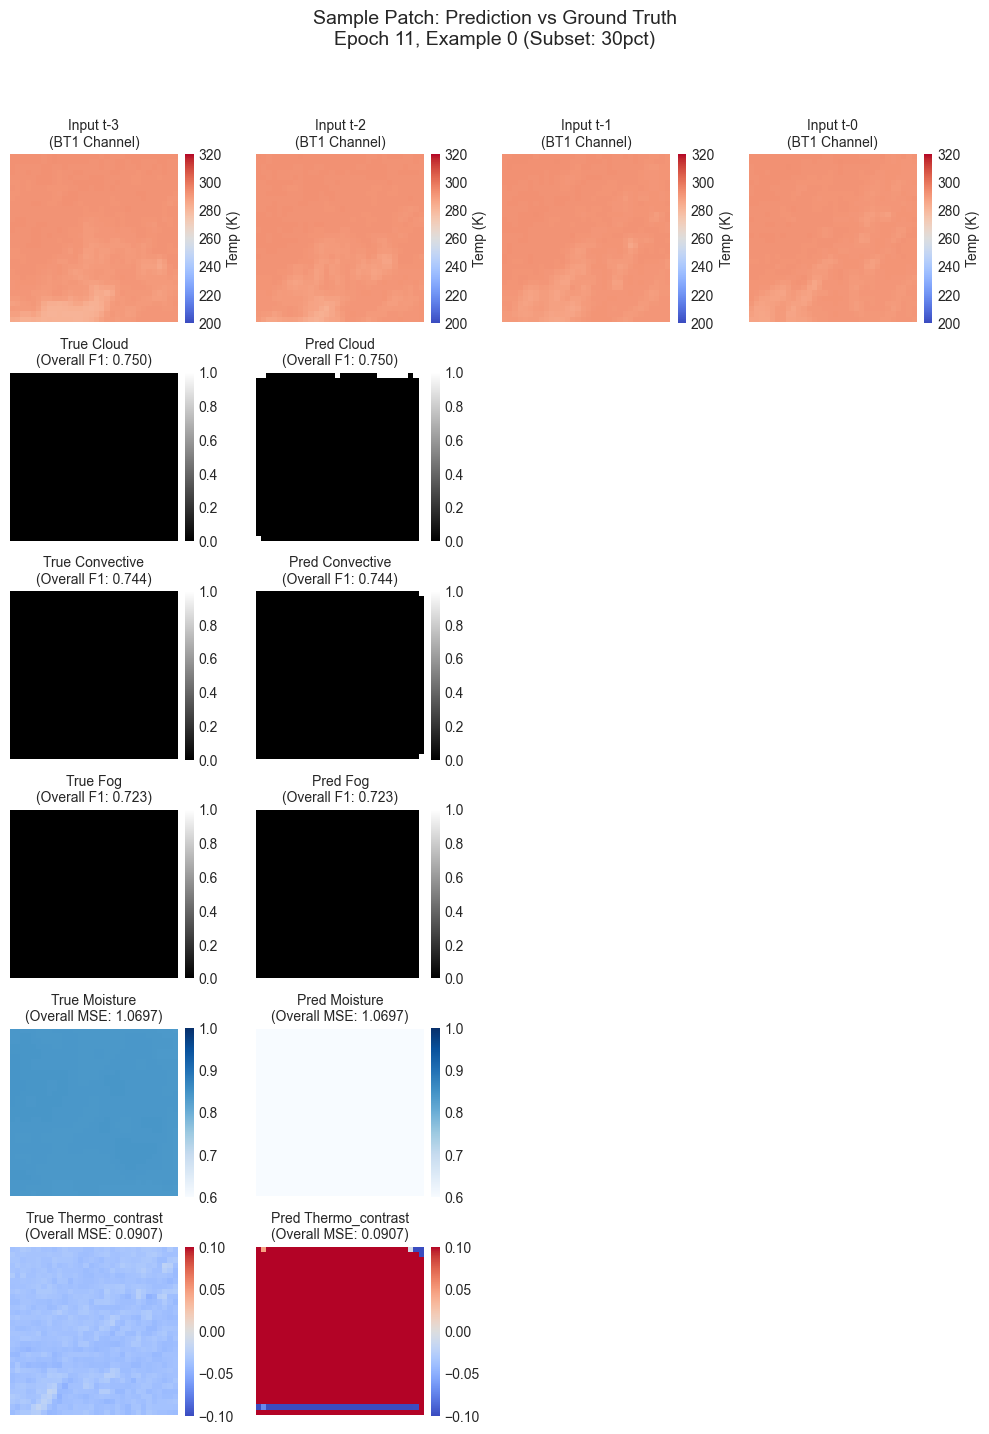

----------------------------------------------------------------------
Description: Sample Prediction vs Ground Truth Plot
  - Source Checkpoint: model_epoch_11.h5 (Epoch 11)
  - Evaluation Subset: 30pct
  - Shows input sequence (top row, BT1 channel) for one sample patch.
  - Compares Ground Truth (left column) vs Model Prediction (right column) for spatial tasks.
  - Overall metrics (F1/MSE) shown in titles are calculated across the entire subset, not just this patch.
  - Color bars indicate the scale for each map (Temperature in K for input, task-specific scales otherwise).
----------------------------------------------------------------------

[VIS] Attempting to generate Confusion Matrix plot(s)...
      Found valid confusion matrices for: cloud, convective, fog

[VIS] Confusion matrices plot saved successfully to: C:\college\CV\COSMOS\checkpoints\evaluation_confusion_matrices_epoch_11_subset_30pct.png


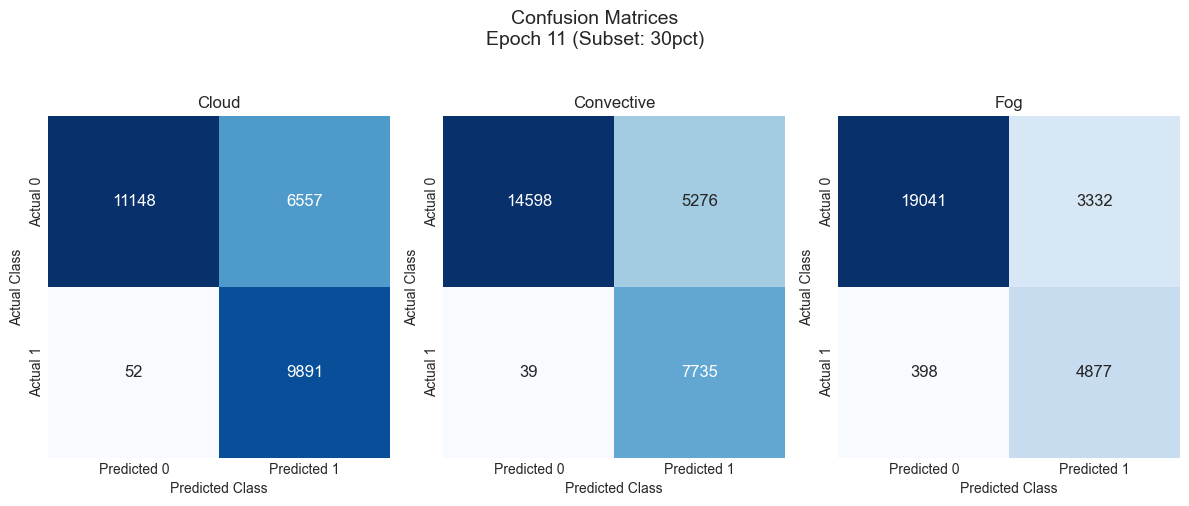

----------------------------------------------------------------------
Description: Confusion Matrix Plot(s)
  - Source Checkpoint: model_epoch_11.h5 (Epoch 11)
  - Evaluation Subset: 30pct
  - Shows confusion matrices for binary classification tasks calculated over the entire subset.
  - TN (Top-Left): True Negatives (Correctly predicted 0)
  - FP (Top-Right): False Positives (Incorrectly predicted 1 when actual was 0)
  - FN (Bottom-Left): False Negatives (Incorrectly predicted 0 when actual was 1)
  - TP (Bottom-Right): True Positives (Correctly predicted 1)
----------------------------------------------------------------------

[INFO] Evaluation Script Finished at: 2025-05-03 17:55:31


In [7]:
print("\n" + "="*60)
print("[VISUALIZATION] Generating Diagnostic Plots")
print("="*60)

# Only proceed if evaluation was successful, model loaded, and produced results
if model is not None and final_metrics and 'error' not in final_metrics and actual_num_samples_for_metrics > 0:

    epoch_str_title = f"Epoch {epoch_number}" if epoch_number != -1 else "Epoch Unknown"
    output_dir = os.path.dirname(ckpt_path_to_eval) or '.'
    epoch_str_file = f"epoch_{epoch_number}" if epoch_number != -1 else "epoch_unknown"

    # --- 1. Generate Sample Prediction vs Ground Truth Plot ---
    print(f"\n[VIS] Attempting to generate Sample Prediction vs Ground Truth plot...")
    try:
        # Get the *first* batch from the evaluation dataset for consistent visualization
        sample_batch = None
        try:
             sample_batch_iterator = iter(eval_ds.take(1))
             sample_batch = next(sample_batch_iterator)
             print("[VIS] Retrieved one sample batch from the dataset.")
        except Exception as e: # Catch StopIteration, OutOfRangeError etc.
             print(f"[WARNING] Could not get a sample batch from dataset: {e}. Skipping sample visualization.")

        if sample_batch:
            x_sample_batch, y_sample_batch = sample_batch
            print(f"[VIS] Generating predictions for the sample batch...")
            pred_sample_batch = model.predict(x_sample_batch, verbose=0)

            idx_in_batch_to_plot = 0
            if x_sample_batch.shape[0] > idx_in_batch_to_plot:
                input_patch_sequence = x_sample_batch[idx_in_batch_to_plot].numpy()

                spatial_tasks = [t for t, d in y_sample_batch.items() if d.ndim == 4 and d.shape[1] == PATCH_SIZE]
                num_spatial_tasks = len(spatial_tasks)
                num_input_frames = input_patch_sequence.shape[0]
                num_rows = 1 + num_spatial_tasks
                num_cols = max(num_input_frames, 2) # Need >=2 cols for True/Pred

                # Adjust figure size for better appearance (can be tuned)
                fig_width = max(10, 2.5 * num_cols) # Ensure minimum width, scale with columns
                fig_height = max(4, 2.5 * num_rows)   # Scale with rows
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), squeeze=False)
                fig.suptitle(f'Sample Patch: Prediction vs Ground Truth\n{epoch_str_title}, Example {idx_in_batch_to_plot} (Subset: {subset_percent_str})', fontsize=14)

                # Plot Input Sequence
                print("[VIS] Plotting input sequence patches...")
                for t in range(num_input_frames):
                    ax = axes[0, t]
                    bt1_data = input_patch_sequence[t, ..., 0] * 300.0 # Channel 0 = BT1, approx denormalized
                    im = ax.imshow(bt1_data, cmap='coolwarm', vmin=200, vmax=320)
                    ax.set_title(f'Input t-{num_input_frames-1-t}\n(BT1 Channel)', fontsize=10)
                    ax.set_xticks([]); ax.set_yticks([])
                    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Temp (K)')
                for t in range(num_input_frames, num_cols): axes[0, t].axis('off') # Hide unused input axes

                # Plot True vs Predicted for spatial tasks
                print("[VIS] Plotting True vs Predicted maps for spatial tasks...")
                current_row = 1
                for task_name in spatial_tasks:
                    if task_name not in pred_sample_batch: continue # Skip if prediction missing
                    true_map = y_sample_batch[task_name][idx_in_batch_to_plot].numpy()
                    pred_map = pred_sample_batch[task_name][idx_in_batch_to_plot]

                    # Plot settings (customize per task as needed)
                    vmin, vmax, cmap, plot_pred_map = None, None, 'viridis', pred_map
                    task_metric_str = ""
                    if task_name in ['cloud', 'convective', 'fog']: # Classification
                        vmin, vmax, cmap = 0, 1, 'gray'
                        plot_pred_map = (pred_map >= 0.5).astype(float)
                        f1_val = final_metrics.get(f'{task_name}_f1', float('nan'))
                        task_metric_str = f'(Overall F1: {f1_val:.3f})'
                    elif task_name == 'moisture':
                        vmin, vmax, cmap = 0.6, 1.0, 'Blues'
                        mse_val = final_metrics.get(f'{task_name}_mse', float('nan'))
                        task_metric_str = f'(Overall MSE: {mse_val:.4f})'
                    elif task_name == 'thermo_contrast':
                        vmin, vmax, cmap = -0.1, 0.1, 'coolwarm'
                        mse_val = final_metrics.get(f'{task_name}_mse', float('nan'))
                        task_metric_str = f'(Overall MSE: {mse_val:.4f})'

                    # Plot True
                    ax_true = axes[current_row, 0]
                    im_true = ax_true.imshow(true_map[..., 0], cmap=cmap, vmin=vmin, vmax=vmax)
                    ax_true.set_title(f'True {task_name.capitalize()}\n{task_metric_str}', fontsize=10)
                    ax_true.set_xticks([]); ax_true.set_yticks([])
                    plt.colorbar(im_true, ax=ax_true, fraction=0.046, pad=0.04)
                    # Plot Predicted
                    ax_pred = axes[current_row, 1]
                    im_pred = ax_pred.imshow(plot_pred_map[..., 0], cmap=cmap, vmin=vmin, vmax=vmax)
                    ax_pred.set_title(f'Pred {task_name.capitalize()}\n{task_metric_str}', fontsize=10)
                    ax_pred.set_xticks([]); ax_pred.set_yticks([])
                    plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
                    # Hide unused columns in task row
                    for c in range(2, num_cols): axes[current_row, c].axis('off')
                    current_row += 1

                # Print Non-Spatial Task Predictions
                non_spatial_tasks = [t for t, d in y_sample_batch.items() if t not in spatial_tasks]
                if non_spatial_tasks:
                    print("\n[VIS] Non-Spatial Task Predictions for this Sample:")
                    for task_name in non_spatial_tasks:
                         if task_name in pred_sample_batch:
                             true_val = y_sample_batch[task_name][idx_in_batch_to_plot].numpy()[0]
                             pred_val = pred_sample_batch[task_name][idx_in_batch_to_plot][0]
                             mae_val = final_metrics.get(f'{task_name}_mae', float('nan'))
                             print(f"      {task_name.capitalize()}: True={true_val:.4f}, Pred={pred_val:.4f} (Overall MAE: {mae_val:.6f})")

                # Finalize and Save Sample Plot
                plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle
                plot_filename_preds = f"evaluation_sample_pred_vs_true_{epoch_str_file}_subset_{subset_percent_str}.png"
                plot_path_preds = os.path.join(output_dir, plot_filename_preds)
                try:
                    plt.savefig(plot_path_preds, dpi=150, bbox_inches='tight') # Use bbox_inches for robustness
                    print(f"\n[VIS] Sample prediction plot saved successfully to: {plot_path_preds}")
                    plt.show() # Display the plot

                    # --- Add Description Below Sample Plot ---
                    print("-" * 70)
                    print("Description: Sample Prediction vs Ground Truth Plot")
                    print(f"  - Source Checkpoint: {os.path.basename(ckpt_path_to_eval)} ({epoch_str_title})")
                    print(f"  - Evaluation Subset: {subset_percent_str}")
                    print(f"  - Shows input sequence (top row, BT1 channel) for one sample patch.")
                    print(f"  - Compares Ground Truth (left column) vs Model Prediction (right column) for spatial tasks.")
                    print(f"  - Overall metrics (F1/MSE) shown in titles are calculated across the entire subset, not just this patch.")
                    print(f"  - Color bars indicate the scale for each map (Temperature in K for input, task-specific scales otherwise).")
                    print("-" * 70)

                except Exception as e: print(f"[ERROR] Failed to save or display sample prediction plot: {e}")

            else: print(f"[WARNING] Sample index {idx_in_batch_to_plot} out of range. Skipping sample plot.")

    except Exception as viz_error:
        print(f"[ERROR] An unexpected error occurred during sample visualization generation: {viz_error}")
        traceback.print_exc()


    # --- 2. Generate Confusion Matrix Plot(s) ---
    print(f"\n[VIS] Attempting to generate Confusion Matrix plot(s)...")
    try:
        class_tasks_with_cm = [
            task for task in model.output_names
            if f'{task}_confusion_matrix' in final_metrics and
               isinstance(final_metrics[f'{task}_confusion_matrix'], np.ndarray) and
               final_metrics[f'{task}_confusion_matrix'].shape == (2, 2) # Ensure it's a valid 2x2 CM
        ]
        num_class_tasks = len(class_tasks_with_cm)

        if num_class_tasks > 0:
            print(f"      Found valid confusion matrices for: {', '.join(class_tasks_with_cm)}")
            # Adjust figure size based on number of CMs
            cm_fig_width = max(5, 4 * num_class_tasks) # Width scales with number of plots
            cm_fig_height = 5.0 # Keep height constant
            fig_cm, axes_cm = plt.subplots(1, num_class_tasks, figsize=(cm_fig_width, cm_fig_height), squeeze=False)
            fig_cm.suptitle(f'Confusion Matrices\n{epoch_str_title} (Subset: {subset_percent_str})', fontsize=14)

            for idx, task_name in enumerate(class_tasks_with_cm):
                cm_data = final_metrics[f'{task_name}_confusion_matrix']
                ax = axes_cm[0, idx]
                sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax, square=True, # Use square=True for better aspect
                            xticklabels=['Predicted 0', 'Predicted 1'],
                            yticklabels=['Actual 0', 'Actual 1'],
                            annot_kws={"size": 12}, cbar=False)
                ax.set_title(f'{task_name.capitalize()}', fontsize=12)
                ax.set_ylabel('Actual Class', fontsize=10)
                ax.set_xlabel('Predicted Class', fontsize=10)

            plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust rect for suptitle
            plot_filename_cm = f"evaluation_confusion_matrices_{epoch_str_file}_subset_{subset_percent_str}.png"
            plot_path_cm = os.path.join(output_dir, plot_filename_cm)
            try:
                plt.savefig(plot_path_cm, dpi=120, bbox_inches='tight')
                print(f"\n[VIS] Confusion matrices plot saved successfully to: {plot_path_cm}")
                plt.show()

                # --- Add Description Below Confusion Matrix Plot ---
                print("-" * 70)
                print("Description: Confusion Matrix Plot(s)")
                print(f"  - Source Checkpoint: {os.path.basename(ckpt_path_to_eval)} ({epoch_str_title})")
                print(f"  - Evaluation Subset: {subset_percent_str}")
                print(f"  - Shows confusion matrices for binary classification tasks calculated over the entire subset.")
                print(f"  - TN (Top-Left): True Negatives (Correctly predicted 0)")
                print(f"  - FP (Top-Right): False Positives (Incorrectly predicted 1 when actual was 0)")
                print(f"  - FN (Bottom-Left): False Negatives (Incorrectly predicted 0 when actual was 1)")
                print(f"  - TP (Bottom-Right): True Positives (Correctly predicted 1)")
                print("-" * 70)

            except Exception as e: print(f"\n[ERROR] Failed to save or display confusion matrices plot: {e}")
        else:
             print("[INFO] No valid 2x2 confusion matrix data found for visualization.")

    except Exception as viz_error:
        print(f"[ERROR] An unexpected error occurred during confusion matrix visualization: {viz_error}")
        traceback.print_exc()

# Handle cases where visualization could not run
elif model is None:
    print("[INFO] Skipping visualizations because the model could not be loaded (check Cell 3 errors).")
elif 'error' in final_metrics:
     print(f"[INFO] Skipping visualizations due to evaluation error in Cell 3: {final_metrics.get('error', 'Unknown error')}")
elif actual_num_samples_for_metrics <= 0:
    print("[INFO] Skipping visualizations as no aligned samples were available for metric calculation.")
else:
    print("[INFO] Skipping visualizations for an unknown reason (check script status).")

print("\n" + "="*60)
print(f"[INFO] Evaluation Script Finished at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)